In [ ]:
#ownerpath = f'/Users/lenfn/Documents/AST 443/AST 443 Group 5'

In [3]:
ownerpath = f'/content/drive/MyDrive/AST 443 Group 5'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [23]:
import os
from matplotlib import pyplot as plt
from matplotlib import colors
from astropy.io import fits
from IPython.display import Image
import math
import numpy as np
#import sep

import glob
import matplotlib.colors as colors
from astropy.io import ascii
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from astropy.visualization import make_lupton_rgb, ZScaleInterval
zscale=ZScaleInterval()
from astropy.table import Table
#from astroquery.astrometry_net import AstrometryNet
from astropy.stats import sigma_clipped_stats

#from photutils.datasets import load_star_image
#from photutils.detection import DAOStarFinder
#from photutils.aperture import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
#AstrometryNet.key = 'kwbavttkhitkoaeo'

%matplotlib inline

from scipy import stats
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from astropy.io import fits
from scipy.ndimage import shift

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Spectra Dark Frames

In [38]:
#Open the darks files and grab the data
raw_darks_120=[]

for i in range(5):
    dark_file=f'{ownerpath}/Lab 3/20tau/darks/darks_120s_.0000000{i}.DARK.FIT'
    dark_file_data=fits.open(dark_file)
    raw_darks_120.append(dark_file_data[0].data)

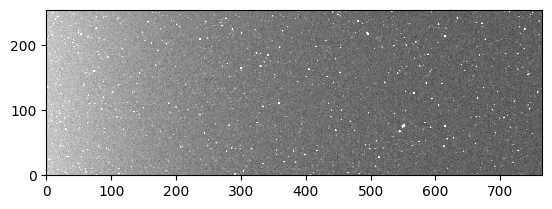

In [39]:
plt.imshow(raw_darks_120[2], vmin=np.mean(raw_darks_120[2])-np.std(raw_darks_120[2]),vmax=np.mean(raw_darks_120[2])+np.std(raw_darks_120[2]), cmap='gray', origin='lower')

## Master Dark Frame

In [40]:
#Average the dark frames to create the master dark
master_dark = np.median(raw_darks_120, axis=0)

# Spectra Flat Fields

In [41]:
#Open the flat field files and grab the data
raw_flats_120=[]

for i in range(5):
    flat_file=f'{ownerpath}/Lab 3/20tau/flats/flats_120s_.0000000{i}.FLAT.FIT'
    flat_file_data=fits.open(flat_file)
    raw_flats_120.append(flat_file_data[0].data)

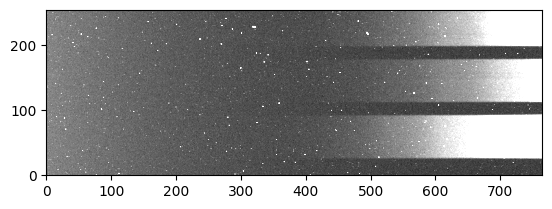

In [42]:
plt.imshow(raw_flats_120[2], vmin=np.mean(raw_flats_120[2])-np.std(raw_flats_120[2]),vmax=np.mean(raw_flats_120[2])+np.std(raw_flats_120[2]), cmap='gray', origin='lower')

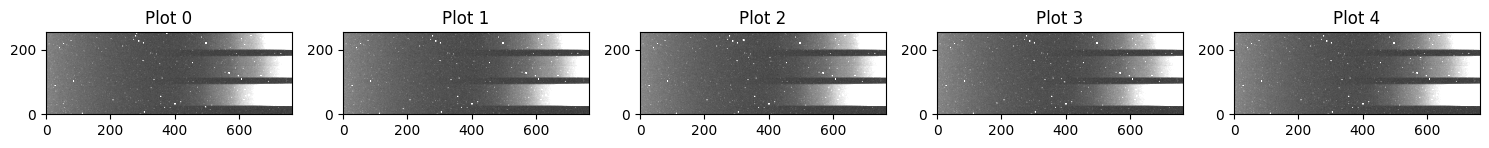

In [43]:
# All 5 Flat Fields
fig, axes = plt.subplots(1, 5, figsize=(15, 25))

# Loop over each subplot and display the images
for i in range(5):
    ax = axes[i]  # Select the appropriate axis
    ax.imshow(raw_flats_120[i],
              vmin=np.mean(raw_flats_120[i]) - np.std(raw_flats_120[i]),
              vmax=np.mean(raw_flats_120[i]) + np.std(raw_flats_120[i]),
              cmap='gray',
              origin='lower')
    ax.set_title(f"Plot {i}")
    #ax.axis('off')  # Optional: Hide axes for a cleaner look

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

## Master Flat Field

In [44]:
#Average the flat field frames to create the master flat field
master_flat = np.median(raw_flats_120, axis=0)

### Master Flat Field (Dark Subtracted and Normalized)

In [45]:
# Subtract the master dark from the master flat field
flat_dark_subtracted = master_flat - master_dark

# Set negative values to zero (optional)
flat_dark_subtracted[flat_dark_subtracted < 0] = 0

# Normalize
flat_dark_subtracted_normalized = flat_dark_subtracted / np.mean(flat_dark_subtracted)

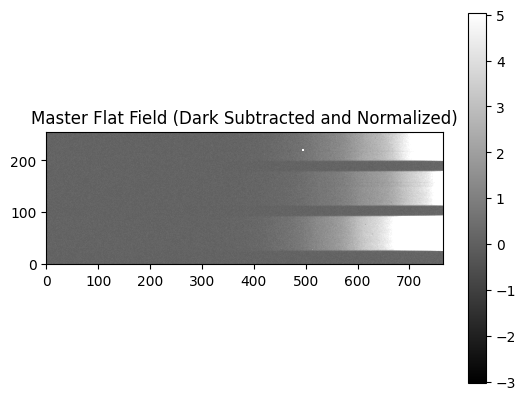

In [46]:
# Set negative values to zero
flat_dark_subtracted_normalized[flat_dark_subtracted_normalized < 0] = 0

# Display the normalized master flat field with darks subtracted using customized color scaling
plt.imshow(flat_dark_subtracted_normalized,
           vmin=np.mean(flat_dark_subtracted_normalized) - (2 * np.std(flat_dark_subtracted_normalized)),
           vmax=np.mean(flat_dark_subtracted_normalized) + (2 * np.std(flat_dark_subtracted_normalized)),
           cmap='gray', origin='lower')

plt.title("Master Flat Field (Dark Subtracted and Normalized)")
plt.colorbar()
plt.show()

# 20 Tau Light Frames

In [47]:
#Open the 20 tau light frame files and extract the data
raw_20tau=[]

for i in range(10):
    tau20_file = f'{ownerpath}/Lab 3/20tau/pleiades_light/20tau_light_120s_.0000000{i}.FIT'
    tau20_file_data=fits.open(tau20_file)
    raw_20tau.append(tau20_file_data[0].data)

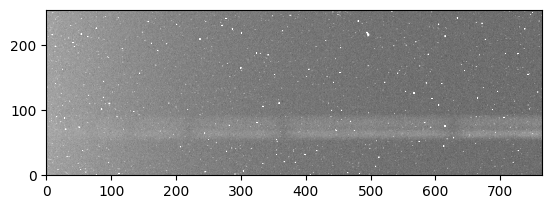

In [48]:
plt.imshow(raw_20tau[4], vmin=np.mean(raw_20tau[4])-(2*np.std(raw_20tau[4])),vmax=np.mean(raw_20tau[2])+(2*np.std(raw_20tau[4])), cmap='gray', origin='lower')

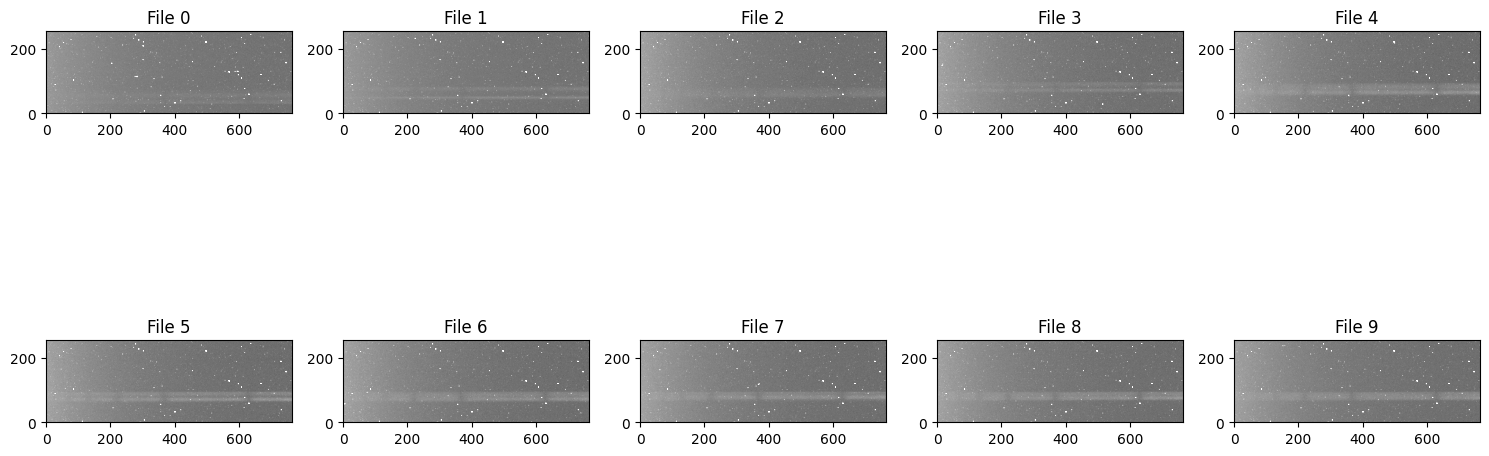

In [49]:
# All 10 light frames of 20 Tau
fig, axes = plt.subplots(2, 5, figsize=(15, 8))  # 2 rows, 5 columns

# Loop through each image
for i, ax in enumerate(axes.flat):
    if i < len(raw_20tau):  # Ensure we're not going out of bounds
        ax.imshow(
            raw_20tau[i],
            vmin=np.mean(raw_20tau[i]) - (2 * np.std(raw_20tau[i])),
            vmax=np.mean(raw_20tau[i]) + (2 * np.std(raw_20tau[i])),
            cmap='gray',
            origin='lower'
        )
        ax.set_title(f"File {i}")  # Title for each plot
        #ax.axis('off')

plt.tight_layout()  # Adjust spacing
plt.show()

# 20 Tau (Dark Subtracted)

In [50]:
#Subtract the master dark from each light frame (20 Tau light frames)
darksubtracted_20tau = []
for i in range(len(raw_20tau)):
    darksubtracted_frame = raw_20tau[i] - master_dark
    darksubtracted_20tau.append(darksubtracted_frame)

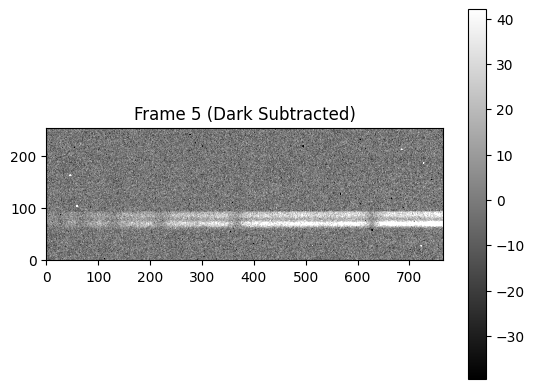

In [51]:
# Display Frame n
frame_index = 5  #Frame 0 to 9

# Display the selected frame with customized color scale
plt.imshow(darksubtracted_20tau[frame_index],
           vmin=np.mean(darksubtracted_20tau[frame_index]) - (2 * np.std(darksubtracted_20tau[frame_index])),
           vmax=np.mean(darksubtracted_20tau[frame_index]) + (2 * np.std(darksubtracted_20tau[frame_index])),
           cmap='gray', origin='lower')

# Add title and labels
plt.title(f"Frame {frame_index} (Dark Subtracted)")
plt.colorbar()  # Optional: Show a color bar

# Show the plot
plt.show()

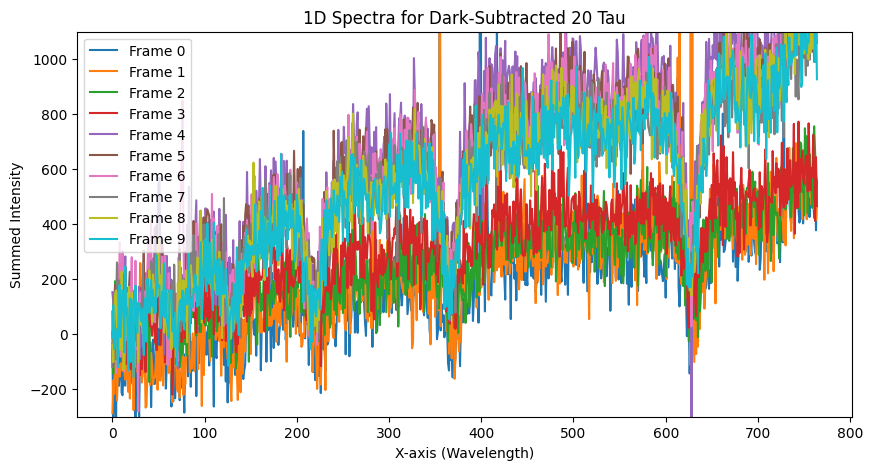

In [145]:
# List to hold the cut data of each dark-subtracted 20 Tau frame
final_20tau_cut_dark = []

# Define the y-axis ranges for each frame
y_ranges_20tau = [(27, 63), (44, 80), (46, 82), (62, 98), (56, 92),
                  (60, 96), (59, 95), (60, 96), (61, 97), (61, 97)]

# Loop through each dark-subtracted 20 Tau frame, cut along y-axis, and extract the data
for i in range(len(darksubtracted_20tau)):  # Ensure we go through all dark-subtracted frames
    frame_data = darksubtracted_20tau[i]  # Get the dark-subtracted frame data

    # Cut the frame data along the y-axis according to the specified range
    y_start, y_end = y_ranges_20tau[i]
    cut_frame_data = frame_data[y_start:y_end, :]  # Cut the frame

    # Append the cut frame data to the list
    final_20tau_cut_dark.append(cut_frame_data)

# List to hold the summed 1D spectra for each cut dark-subtracted 20 Tau frame
summed_20tau = []

# Sum along the y-axis for each cut dark-subtracted 20 Tau frame
for frame in final_20tau_cut_dark:
    summed_1d = frame.sum(axis=0)  # Sum along the y-axis
    summed_20tau.append(summed_1d)

# Plot the 1D spectra for the dark-subtracted 20 Tau frames
plt.figure(figsize=(10, 5))
for i, spectrum in enumerate(summed_20tau):
    plt.plot(spectrum, label=f'Frame {i}')  # Plot each frame with a label
plt.title("1D Spectra for Dark-Subtracted 20 Tau")
plt.xlabel("X-axis (Wavelength)")
plt.ylabel("Summed Intensity")
plt.ylim(-300, 1100)
plt.legend()  # Add legend to distinguish each frame
plt.show()

In [195]:
combined_20tau = np.mean(summed_20tau, axis=0)

In [196]:
# np.nanargmax(combined_20tau)

In [197]:
# combined_20tau[628] = np.nan

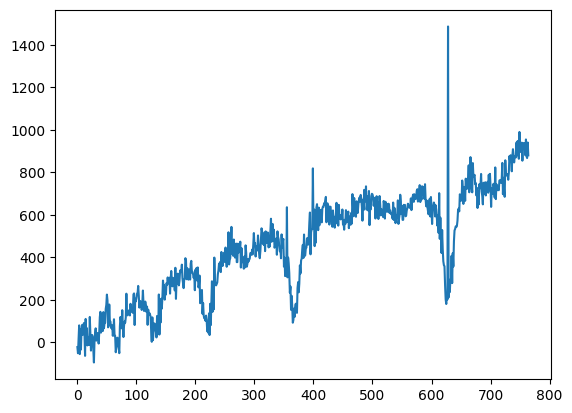

In [198]:
plt.plot(combined_20tau)

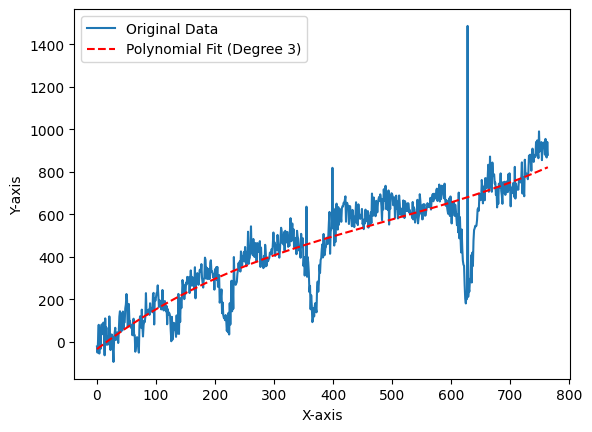

In [199]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming combined_20tau is a numpy array or list of data points
# Example: combined_20tau = np.array([...])

# Degree of the polynomial you want to fit (e.g., degree 3)
degree = 3

# Fit a polynomial of the specified degree to the data
coefficients = np.polyfit(np.arange(len(combined_20tau)), combined_20tau, degree)

# Create a polynomial object from the coefficients
polynomial = np.poly1d(coefficients)

# Generate y-values of the fitted polynomial
fitted_values = polynomial(np.arange(len(combined_20tau)))

# Plot the original data and the polynomial fit
plt.plot(combined_20tau, label='Original Data')
plt.plot(fitted_values, label=f'Polynomial Fit (Degree {degree})', linestyle='--', color='red')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

# 20 Tau (Dark subtracted and Flat multiplied)

In [52]:
# Multiply each dark-subtracted 20 Tau frame by the normalized master flat field
final_20tau = []
for i in range(len(darksubtracted_20tau)):
    final_frame = darksubtracted_20tau[i] * flat_dark_subtracted_normalized
    final_20tau.append(final_frame)

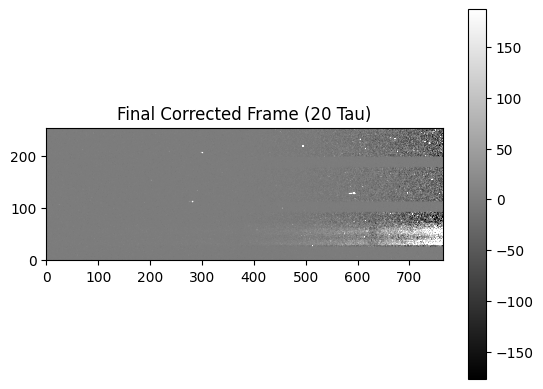

In [53]:
# Display the first final corrected frame (20 Tau)
plt.imshow(final_20tau[0],
           vmin=np.mean(final_20tau[8]) - (1.25 * np.std(final_20tau[8])),
           vmax=np.mean(final_20tau[8]) + (1.25 * np.std(final_20tau[8])),
           cmap='gray', origin='lower')

# Add title and colorbar
plt.title("Final Corrected Frame (20 Tau)")
plt.colorbar()  # Show a color bar

# Show the plot
plt.show()

# eta Tau Light Frames

In [54]:
#Open the etatau light frame files and extract the data
raw_etatau=[]

for i in range(10):
    taueta_file = f'{ownerpath}/Lab 3/20tau/pleiades_light/etatau_light_120s_.0000000{i}.FIT'
    taueta_file_data=fits.open(taueta_file)
    raw_etatau.append(taueta_file_data[0].data)

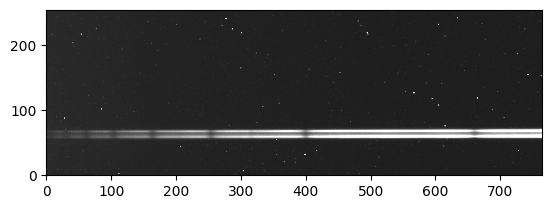

In [55]:
plt.imshow(raw_etatau[2], vmin=np.mean(raw_etatau[2])-np.std(raw_etatau[2]),vmax=np.mean(raw_etatau[2])+(5*np.std(raw_etatau[2])), cmap='gray', origin='lower')

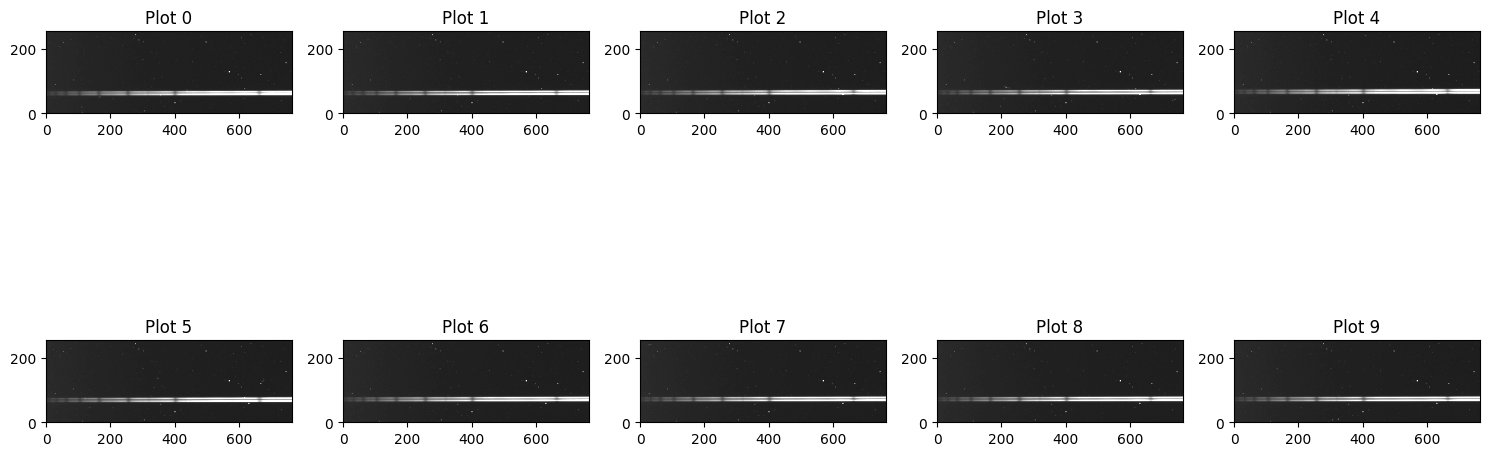

In [56]:
# All 10 light frames of eta Tau
fig, axes = plt.subplots(2, 5, figsize=(15, 8))  # 2 rows, 5 columns grid for 10 plots
axes = axes.ravel()  # Flatten the 2D array of axes to make indexing easier

for i in range(10):  # Loop through the 10 indices (0 to 9)
    axes[i].imshow(raw_etatau[i],
                   vmin=np.mean(raw_etatau[i]) - np.std(raw_etatau[i]),
                   vmax=np.mean(raw_etatau[i]) + (5 * np.std(raw_etatau[i])),
                   cmap='gray', origin='lower')
    axes[i].set_title(f"Plot {i}")  # Optionally, label each subplot
    #axes[i].axis('off')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# eta Tau (Dark Subtracted)

In [57]:
# Subtract the master dark from each Eta Tau light frame
darksubtracted_etatau = []
for i in range(len(raw_etatau)):
    darksubtracted_frame = raw_etatau[i] - master_dark
    darksubtracted_etatau.append(darksubtracted_frame)

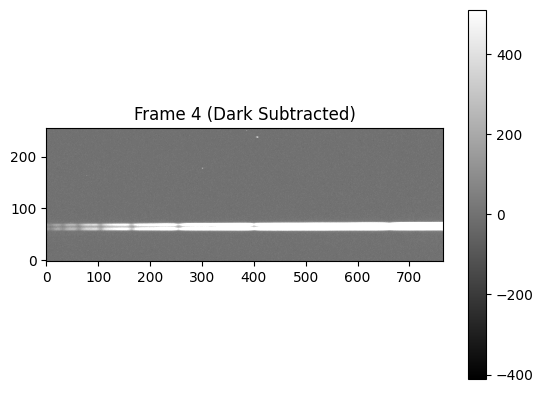

In [58]:
# Display Frame n
frame_index = 4  # Example: Show the 5th frame (index 4)

# Display the selected frame with customized color scale
plt.imshow(darksubtracted_etatau[frame_index],
           vmin=np.mean(darksubtracted_etatau[frame_index]) - (2 * np.std(darksubtracted_etatau[frame_index])),
           vmax=np.mean(darksubtracted_etatau[frame_index]) + (2 * np.std(darksubtracted_etatau[frame_index])),
           cmap='gray', origin='lower')

# Add title and labels
plt.title(f"Frame {frame_index} (Dark Subtracted)")
plt.colorbar()  # Optional: Show a color bar

# Show the plot
plt.show()

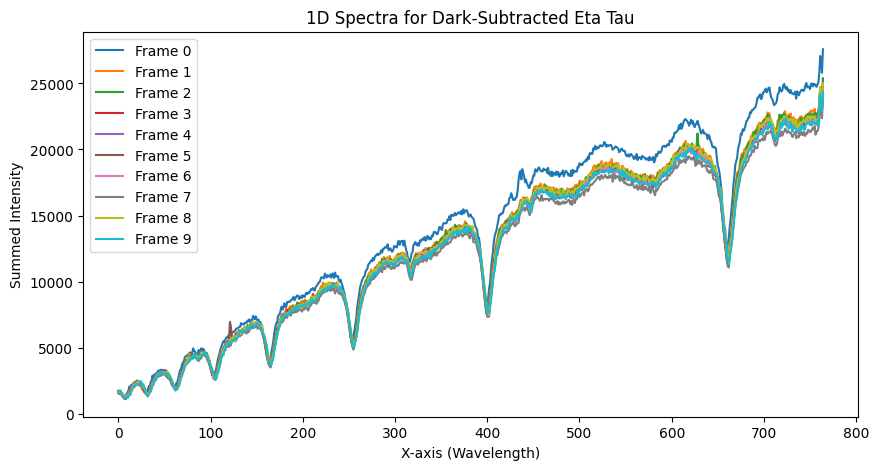

In [137]:
# List to hold the cut data of each dark-subtracted Eta Tau frame
final_etatau_cut_dark = []

# Define the y-axis ranges for each frame
y_ranges_eta = [(51, 71), (51, 71), (54, 74), (55, 75), (57, 77),
                (58, 78), (60, 80), (61, 81), (61, 81), (61, 81)]

# Loop through each dark-subtracted Eta Tau frame, cut along y-axis, and extract the data
for i in range(len(darksubtracted_etatau)):  # Ensure we go through all dark-subtracted frames
    frame_data = darksubtracted_etatau[i]  # Get the dark-subtracted frame data

    # Cut the frame data along the y-axis according to the specified range
    y_start, y_end = y_ranges_eta[i]
    cut_frame_data = frame_data[y_start:y_end, :]  # Cut the frame

    # Append the cut frame data to the list
    final_etatau_cut_dark.append(cut_frame_data)

# List to hold the summed 1D spectra for each cut dark-subtracted Eta Tau frame
summed_etatau = []

# Sum along the y-axis for each cut dark-subtracted Eta Tau frame
for frame in final_etatau_cut_dark:
    summed_1d = frame.sum(axis=0)  # Sum along the y-axis
    summed_etatau.append(summed_1d)

# Plot the 1D spectra for the dark-subtracted Eta Tau frames
plt.figure(figsize=(10, 5))
for i, spectrum in enumerate(summed_etatau):
    plt.plot(spectrum, label=f'Frame {i}')  # Plot each frame with a label
plt.title("1D Spectra for Dark-Subtracted Eta Tau")
plt.xlabel("X-axis (Wavelength)")
plt.ylabel("Summed Intensity")
plt.legend()  # Add legend to distinguish each frame
plt.show()

# eta Tau (Dark and Flat Subtracted)

In [59]:
# Multiply each dark-subtracted Eta Tau frame by the normalized master flat field
final_etatau = []
for i in range(len(darksubtracted_etatau)):
    final_frame = darksubtracted_etatau[i] * flat_dark_subtracted_normalized
    final_etatau.append(final_frame)

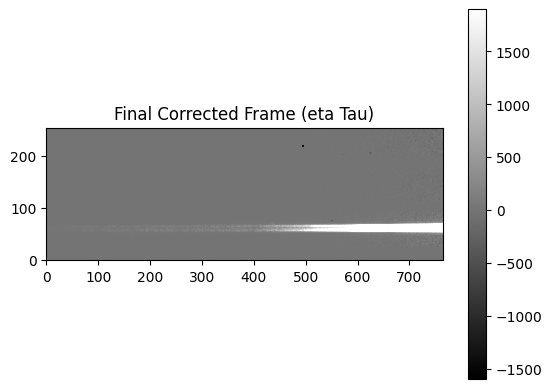

In [91]:
# Display the first final corrected frame (Eta Tau)
plt.imshow(final_etatau[0],
           vmin=np.mean(final_etatau[0]) - (1 * np.std(final_etatau[0])),
           vmax=np.mean(final_etatau[0]) + (1 * np.std(final_etatau[0])),
           cmap='gray', origin='lower')

# Add title and colorbar
plt.title("Final Corrected Frame (eta Tau)")
plt.colorbar()  # Show a color bar

# Show the plot
plt.show()

# q Tau Light Frames

In [61]:
#Open the q Tau light frame files and extract the data
raw_qtau=[]

for i in range(10):
    tauq_file = f'{ownerpath}/Lab 3/20tau/pleiades_light/qtau_light_120s_.0000000{i}.FIT'
    tauq_file_data=fits.open(tauq_file)
    raw_qtau.append(tauq_file_data[0].data)

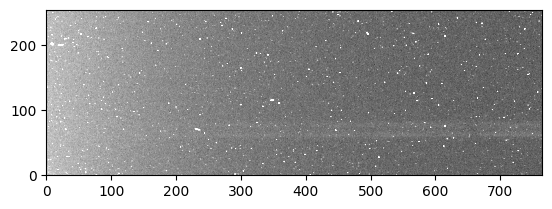

In [62]:
plt.imshow(raw_qtau[2], vmin=np.mean(raw_qtau[2])-(np.std(raw_qtau[2])),vmax=np.mean(raw_qtau[2])+(np.std(raw_qtau[2])), cmap='gray', origin='lower')

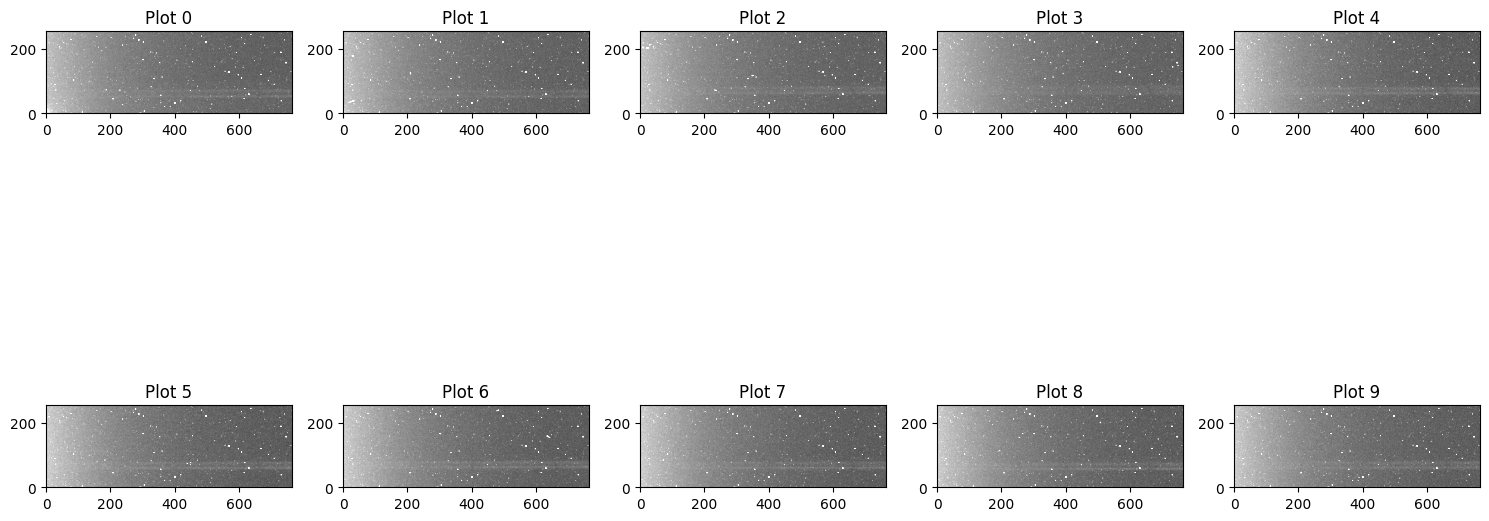

In [63]:
# All 10 light frames of q Tau
fig, axes = plt.subplots(2, 5, figsize=(15, 10))  # 2 rows, 5 columns grid for 10 plots
axes = axes.ravel()  # Flatten the 2D array of axes to make indexing easier

for i in range(10):  # Loop through the 10 indices (0 to 9)
    axes[i].imshow(raw_qtau[i],
                   vmin=np.mean(raw_qtau[i]) - np.std(raw_qtau[i]),
                   vmax=np.mean(raw_qtau[i]) + np.std(raw_qtau[i]),
                   cmap='gray', origin='lower')
    axes[i].set_title(f"Plot {i}")  # Optionally, label each subplot
    #axes[i].axis('off')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# q Tau (Dark Subtracted)

In [64]:
# Subtract the master dark from each q Tau light frame
darksubtracted_qtau = []
for i in range(len(raw_qtau)):
    darksubtracted_frame = raw_qtau[i] - master_dark
    darksubtracted_qtau.append(darksubtracted_frame)

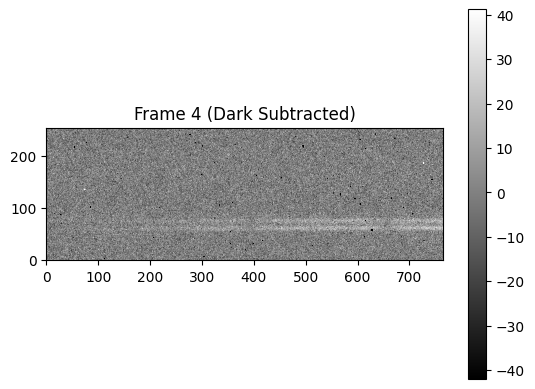

In [65]:
# Display Frame n
frame_index = 4  # Example: Show the 5th frame (index 4)

# Display the selected frame with customized color scale
plt.imshow(darksubtracted_qtau[frame_index],
           vmin=np.mean(darksubtracted_qtau[frame_index]) - (2 * np.std(darksubtracted_qtau[frame_index])),
           vmax=np.mean(darksubtracted_qtau[frame_index]) + (2 * np.std(darksubtracted_qtau[frame_index])),
           cmap='gray', origin='lower')

# Add title and labels
plt.title(f"Frame {frame_index} (Dark Subtracted)")
plt.colorbar()  # Optional: Show a color bar

# Show the plot
plt.show()

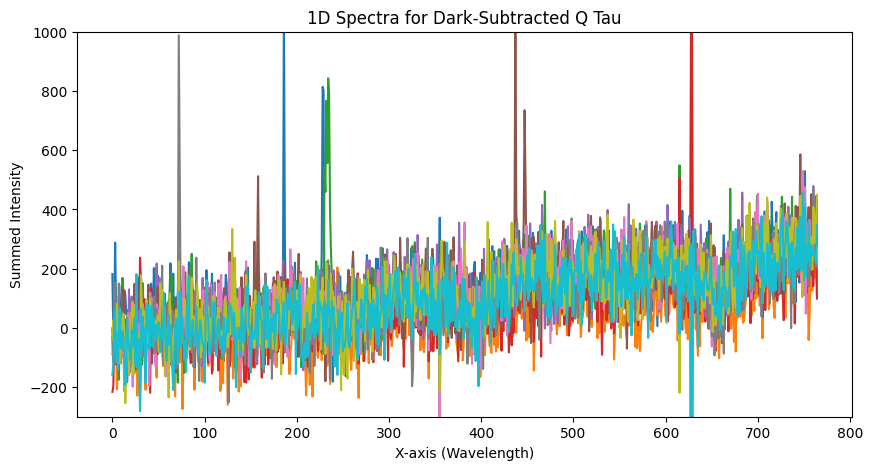

In [143]:
# List to hold the cut data of each dark-subtracted Q Tau frame
final_qtau_cut_dark = []

# Define the y-axis ranges for each frame
y_ranges_qtau = [(46, 76), (45, 75), (56, 86), (57, 87), (54, 84),
                 (52, 82), (54, 84), (53, 83), (48, 78), (52, 82)]

# Loop through each dark-subtracted Q Tau frame, cut along y-axis, and extract the data
for i in range(len(darksubtracted_qtau)):  # Ensure we go through all dark-subtracted frames
    frame_data = darksubtracted_qtau[i]  # Get the dark-subtracted frame data

    # Cut the frame data along the y-axis according to the specified range
    y_start, y_end = y_ranges_qtau[i]
    cut_frame_data = frame_data[y_start:y_end, :]  # Cut the frame

    # Append the cut frame data to the list
    final_qtau_cut_dark.append(cut_frame_data)

# List to hold the summed 1D spectra for each cut dark-subtracted Q Tau frame
summed_qtau = []

# Sum along the y-axis for each cut dark-subtracted Q Tau frame
for frame in final_qtau_cut_dark:
    summed_1d = frame.sum(axis=0)  # Sum along the y-axis
    summed_qtau.append(summed_1d)

# Plot the 1D spectra for the dark-subtracted Q Tau frames
plt.figure(figsize=(10, 5))
for i, spectrum in enumerate(summed_qtau):
    plt.plot(spectrum, label=f'Frame {i}')  # Plot each frame with a label
plt.title("1D Spectra for Dark-Subtracted Q Tau")
plt.xlabel("X-axis (Wavelength)")
plt.ylabel("Summed Intensity")
plt.ylim(-300, 1000)
#plt.legend()  # Add legend to distinguish each frame
plt.show()

# q Tau (Dark and Flat Subtracted)

In [66]:
# Multiply each dark-subtracted Q Tau frame by the normalized master flat field
final_qtau = []
for i in range(len(darksubtracted_qtau)):
    final_frame = darksubtracted_qtau[i] * flat_dark_subtracted_normalized
    final_qtau.append(final_frame)

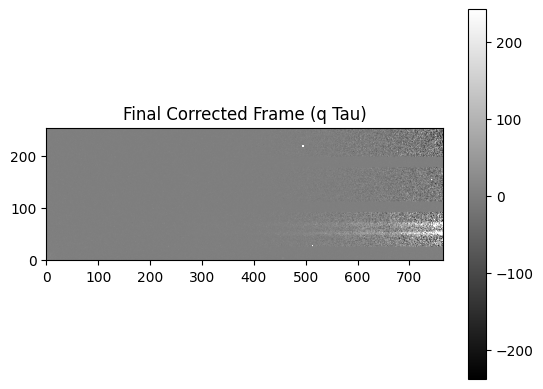

In [67]:
# Display the first final corrected frame (Q Tau)
plt.imshow(final_qtau[0],
           vmin=np.mean(final_qtau[0]) - (2 * np.std(final_qtau[0])),
           vmax=np.mean(final_qtau[0]) + (2 * np.std(final_qtau[0])),
           cmap='gray', origin='lower')

# Add title and colorbar
plt.title("Final Corrected Frame (q Tau)")
plt.colorbar()  # Show a color bar

# Show the plot
plt.show()

# (Don't run) Save all the final corrected images

In [92]:
# # Directory where we will save the corrected frames
# save_directory = '/content/drive/MyDrive/AST 443 Group 5/Lab 3/20tau/corrected_pleiades_light'

# # Ensure the directory exists
# os.makedirs(save_directory, exist_ok=True)

# # Step 1: Save the final 20 Tau frames
# for i, frame in enumerate(final_20tau):
#     # Create the filename for each frame
#     filename = f'{save_directory}/final_20tau_frame_{i:03d}.FIT'

#     # Save the frame as a FITS file
#     fits.writeto(filename, frame, overwrite=True)

# # Step 2: Save the final Eta Tau frames
# for i, frame in enumerate(final_etatau):
#     # Create the filename for each frame
#     filename = f'{save_directory}/final_etatau_frame_{i:03d}.FIT'

#     # Save the frame as a FITS file
#     fits.writeto(filename, frame, overwrite=True)

# # Step 3: Save the final Q Tau frames
# for i, frame in enumerate(final_qtau):
#     # Create the filename for each frame
#     filename = f'{save_directory}/final_qtau_frame_{i:03d}.FIT'

#     # Save the frame as a FITS file
#     fits.writeto(filename, frame, overwrite=True)

# print("Frames have been saved successfully!")

# Cut 20 Tau Light Frames

In [69]:
# List to hold the data of each corrected 20 Tau frame
final_20tau = []

# Loop through each corrected frame, open it, and extract the data
for i in range(10):
    tau20_corrected_file = f'{ownerpath}/Lab 3/20tau/corrected_pleiades_light/final_20tau_frame_00{i}.FIT'
    tau20_corrected_file_data = fits.open(tau20_corrected_file)
    final_20tau.append(tau20_corrected_file_data[0].data)

In [70]:
# List to hold the cut data of each corrected 20 Tau frame
final_20tau_cut = []

# Define the y-axis ranges for each frame
y_ranges = [(27, 63), (44, 80), (46, 82), (62, 98), (56, 92),
            (60, 96), (59, 95), (60, 96), (61, 97), (61, 97)]

# Loop through each corrected frame, open it, cut along y-axis, and extract the data
for i in range(10):
    tau20_corrected_file = f'{ownerpath}/Lab 3/20tau/corrected_pleiades_light/final_20tau_frame_00{i}.FIT'
    tau20_corrected_file_data = fits.open(tau20_corrected_file)

    # Get the full frame data
    frame_data = tau20_corrected_file_data[0].data

    # Cut the frame data along the y-axis according to the specified range
    y_start, y_end = y_ranges[i]
    cut_frame_data = frame_data[y_start:y_end, :]

    # Append the cut frame data to the list
    final_20tau_cut.append(cut_frame_data)

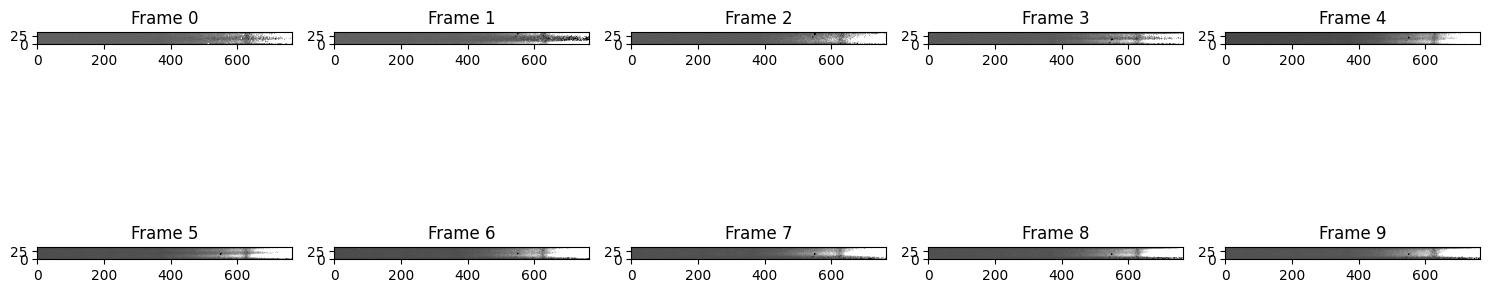

In [71]:
# Set up the number of frames and create a grid for plotting
num_frames = len(final_20tau_cut)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows and 5 columns

# Loop through each cut frame and display it
for i, ax in enumerate(axes.flat):
    if i < num_frames:  # Ensure we're not going out of bounds
        frame = final_20tau_cut[i]
        ax.imshow(
            frame,
            vmin=np.mean(frame) - (1 * np.std(frame)),
            vmax=np.mean(frame) + (1 * np.std(frame)),
            cmap='gray',
            origin='lower'
        )
        ax.set_title(f"Frame {i}")  # Title for each plot
        #ax.axis('off')

plt.tight_layout()
plt.show()

# Cut eta Tau Light Frames

In [72]:
# List to hold the data of each corrected Eta Tau frame
final_etatau = []

# Loop through each corrected frame, open it, and extract the data
for i in range(10):
    etatau_corrected_file = f'{ownerpath}/Lab 3/20tau/corrected_pleiades_light/final_etatau_frame_00{i}.FIT'
    etatau_corrected_file_data = fits.open(etatau_corrected_file)
    final_etatau.append(etatau_corrected_file_data[0].data)

In [73]:
# List to hold the cut data of each corrected Eta Tau frame
final_etatau_cut = []

# Define the y-axis ranges for each frame
y_ranges_eta = [(51, 71), (51, 71), (54, 74), (55, 75), (57, 77),
                (58, 78), (60, 80), (61, 81), (61, 81), (61, 81)]

# Loop through each corrected frame, cut along y-axis, and extract the data
for i in range(10):
    # Get the full frame data
    frame_data = final_etatau[i]

    # Cut the frame data along the y-axis according to the specified range
    y_start, y_end = y_ranges_eta[i]
    cut_frame_data = frame_data[y_start:y_end, :]

    # Append the cut frame data to the list
    final_etatau_cut.append(cut_frame_data)

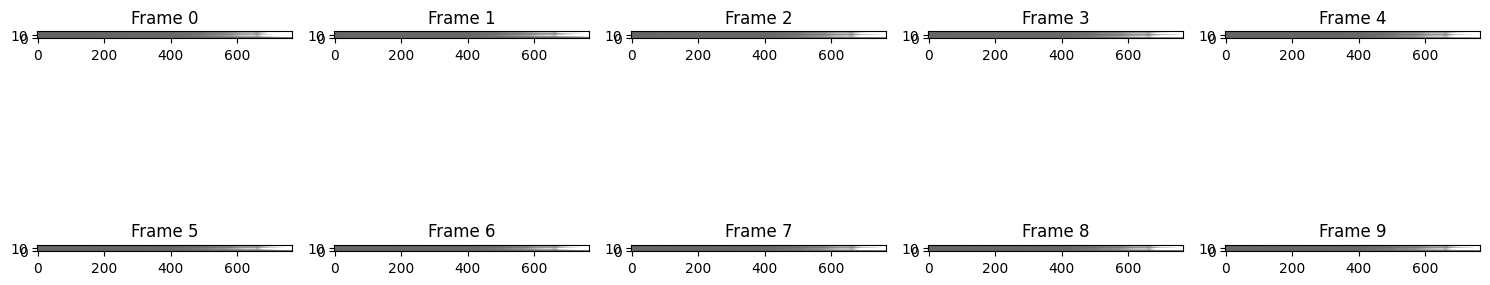

In [74]:
# Set up the number of frames and create a grid for plotting
num_frames = len(final_etatau_cut)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows and 5 columns

# Loop through each cut frame and display it
for i, ax in enumerate(axes.flat):
    if i < num_frames:  # Ensure we're not going out of bounds
        frame = final_etatau_cut[i]
        ax.imshow(
            frame,
            vmin=np.mean(frame) - (2 * np.std(frame)),
            vmax=np.mean(frame) + (2 * np.std(frame)),
            cmap='gray',
            origin='lower'
        )
        ax.set_title(f"Frame {i}")  # Title for each plot
        #ax.axis('off')

plt.tight_layout()
plt.show()

# Cut q Tau Light Frames

In [75]:
# List to hold the data of each corrected Q Tau frame
final_qtau = []

# Loop through each corrected frame, open it, and extract the data
for i in range(10):
    qtau_corrected_file = f'{ownerpath}/Lab 3/20tau/corrected_pleiades_light/final_qtau_frame_00{i}.FIT'
    qtau_corrected_file_data = fits.open(qtau_corrected_file)
    final_qtau.append(qtau_corrected_file_data[0].data)

In [76]:
# List to hold the cut data of each corrected Q Tau frame
final_qtau_cut = []

# Define the y-axis ranges for each frame
y_ranges_qtau = [(46, 76), (45, 75), (56, 86), (57, 87), (54, 84),
                 (52, 82), (54, 84), (53, 83), (48, 78), (52, 82)]

# Loop through each corrected frame, cut along y-axis, and extract the data
for i in range(10):
    # Get the full frame data
    frame_data = final_qtau[i]

    # Cut the frame data along the y-axis according to the specified range
    y_start, y_end = y_ranges_qtau[i]
    cut_frame_data = frame_data[y_start:y_end, :]

    # Append the cut frame data to the list
    final_qtau_cut.append(cut_frame_data)

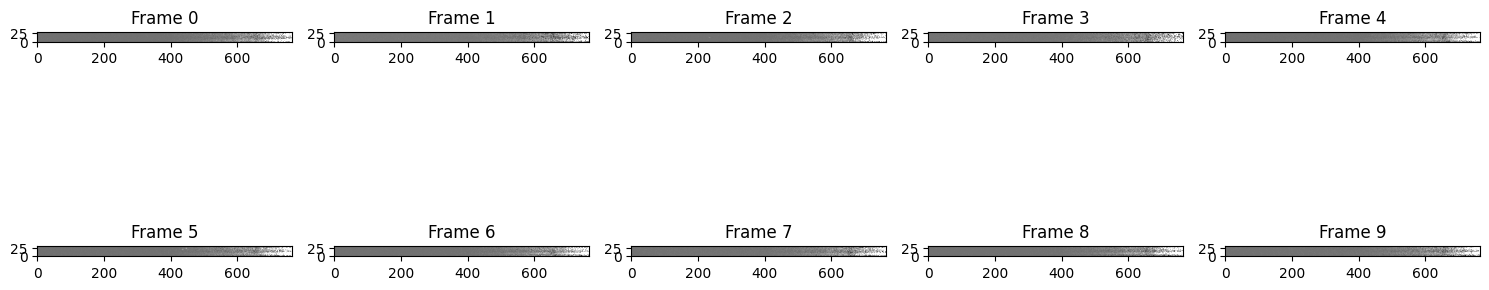

In [77]:
# Set up the number of frames and create a grid for plotting
num_frames = len(final_qtau_cut)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows and 5 columns

# Loop through each cut frame and display it
for i, ax in enumerate(axes.flat):
    if i < num_frames:  # Ensure we're not going out of bounds
        frame = final_qtau_cut[i]
        ax.imshow(
            frame,
            vmin=np.mean(frame) - (2 * np.std(frame)),
            vmax=np.mean(frame) + (2 * np.std(frame)),
            cmap='gray',
            origin='lower'
        )
        ax.set_title(f"Frame {i}")  # Title for each plot
        #ax.axis('off')

plt.tight_layout()
plt.show()

# (Don't run) Save all the cut images

In [78]:
# # Directory where we will save the cut frames
# save_directory = '/content/drive/MyDrive/AST 443 Group 5/Lab 3/20tau/cut_pleiades_light'

# # Ensure the directory exists
# os.makedirs(save_directory, exist_ok=True)

# # Step 1: Save the cut 20 Tau frames
# for i, frame in enumerate(final_20tau_cut):
#     # Create the filename for each frame
#     filename = f'{save_directory}/cut_20tau_frame_{i:03d}.FIT'

#     # Save the frame as a FITS file
#     fits.writeto(filename, frame, overwrite=True)

# # Step 2: Save the cut Eta Tau frames
# for i, frame in enumerate(final_etatau_cut):
#     # Create the filename for each frame
#     filename = f'{save_directory}/cut_etatau_frame_{i:03d}.FIT'

#     # Save the frame as a FITS file
#     fits.writeto(filename, frame, overwrite=True)

# # Step 3: Save the cut Q Tau frames
# for i, frame in enumerate(final_qtau_cut):
#     # Create the filename for each frame
#     filename = f'{save_directory}/cut_qtau_frame_{i:03d}.FIT'

#     # Save the frame as a FITS file
#     fits.writeto(filename, frame, overwrite=True)

# print("Cut frames have been saved successfully!")

# Combined 1D arrays for each target star

In [79]:
# Lists to hold the 1D summed data for each target star
summed_20tau = []
summed_etatau = []
summed_qtau = []

# Sum along the y-axis for each cut frame in 20 Tau
for frame in final_20tau_cut:
    summed_1d = frame.sum(axis=0)  # Sum along y-axis
    summed_20tau.append(summed_1d)

# Sum along the y-axis for each cut frame in Eta Tau
for frame in final_etatau_cut:
    summed_1d = frame.sum(axis=0)
    summed_etatau.append(summed_1d)

# Sum along the y-axis for each cut frame in Q Tau
for frame in final_qtau_cut:
    summed_1d = frame.sum(axis=0)
    summed_qtau.append(summed_1d)

print("1D summed data arrays created successfully!")

1D summed data arrays created successfully!


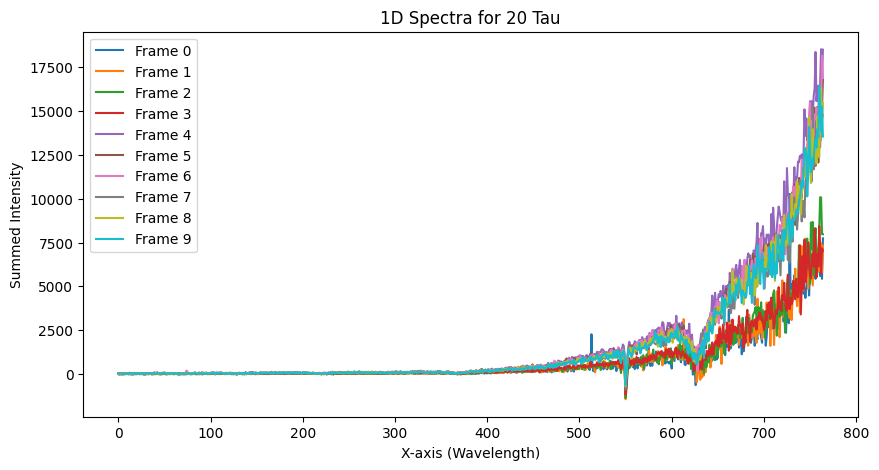

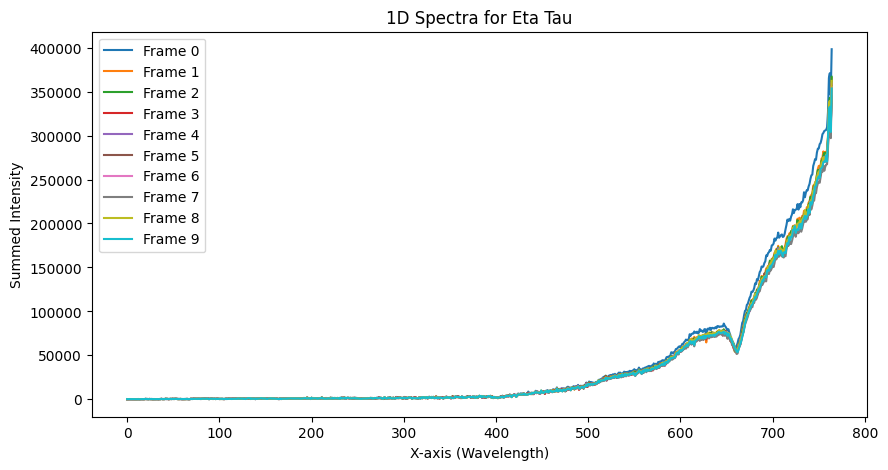

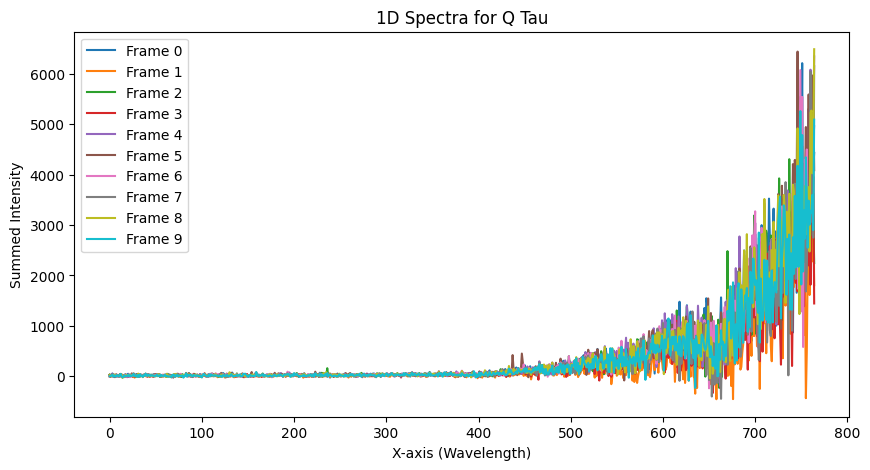

In [80]:
import matplotlib.pyplot as plt

# Plot the 1D spectra for 20 Tau
plt.figure(figsize=(10, 5))
for i, spectrum in enumerate(summed_20tau):
    plt.plot(spectrum, label=f'Frame {i}')
plt.title("1D Spectra for 20 Tau")
plt.xlabel("X-axis (Wavelength)")
plt.ylabel("Summed Intensity")
plt.legend()
plt.show()

# Plot the 1D spectra for Eta Tau
plt.figure(figsize=(10, 5))
for i, spectrum in enumerate(summed_etatau):
    plt.plot(spectrum, label=f'Frame {i}')
plt.title("1D Spectra for Eta Tau")
plt.xlabel("X-axis (Wavelength)")
plt.ylabel("Summed Intensity")
plt.legend()
plt.show()

# Plot the 1D spectra for Q Tau
plt.figure(figsize=(10, 5))
for i, spectrum in enumerate(summed_qtau):
    plt.plot(spectrum, label=f'Frame {i}')
plt.title("1D Spectra for Q Tau")
plt.xlabel("X-axis (Wavelength)")
plt.ylabel("Summed Intensity")
plt.legend()
plt.show()

# Mercury

In [101]:
#Open the mercury frame files and extract the data
raw_mercury=[]

for i in range(2):
    mercury_file = f'{ownerpath}/Lab 3/20tau/mercury_arc_lamp/mercury_light_120s_.0000000{i}.FIT'
    mercury_file_data=fits.open(mercury_file)
    raw_mercury.append(mercury_file_data[0].data)

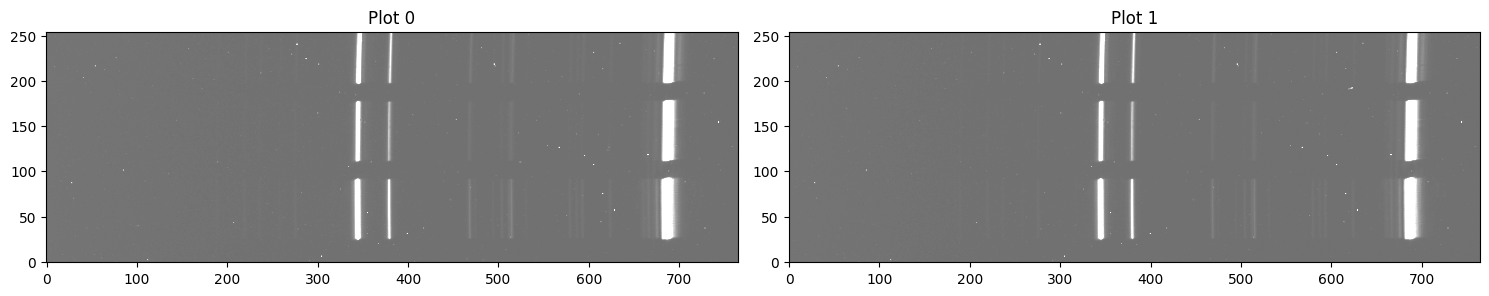

In [103]:
# All 3 mercury frames
fig, axes = plt.subplots(1, 2, figsize=(15, 10))  # 2 rows, 5 columns grid for 10 plots
axes = axes.ravel()  # Flatten the 2D array of axes to make indexing easier

for i in range(2):  # Loop through the 3 indices
    axes[i].imshow(raw_mercury[i],
                   vmin=np.mean(raw_mercury[i]) - np.std(raw_mercury[i]),
                   vmax=np.mean(raw_mercury[i]) + np.std(raw_mercury[i]),
                   cmap='gray', origin='lower')
    axes[i].set_title(f"Plot {i}")  # Optionally, label each subplot
    #axes[i].axis('off')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Mercury (Dark Subtracted)

In [113]:
# List to store the dark-subtracted mercury frames
dark_subtracted_mercury = []

# Subtract the master dark frame from each mercury frame
for frame in raw_mercury:
    dark_subtracted_frame = frame - master_dark
    dark_subtracted_mercury.append(dark_subtracted_frame)

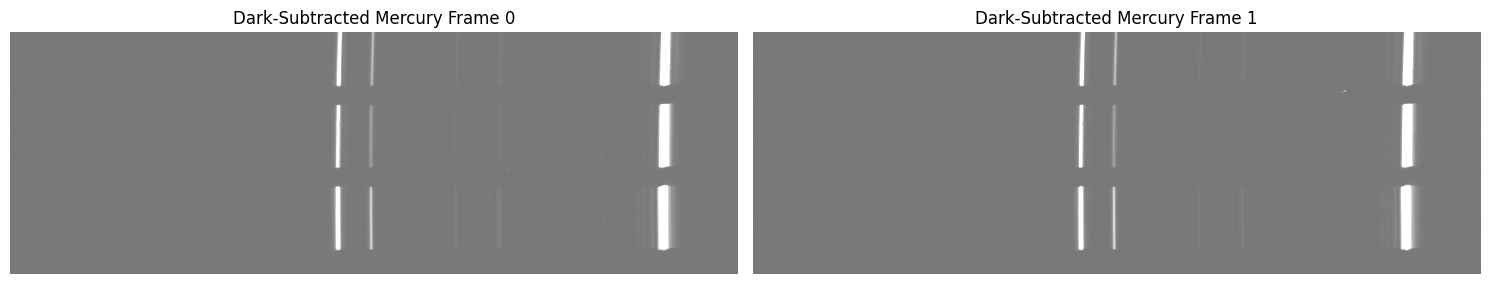

In [114]:
# Plot the dark-subtracted mercury frames
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(
        dark_subtracted_mercury[i],
        vmin=np.mean(dark_subtracted_mercury[i]) - (2 * np.std(dark_subtracted_mercury[i])),
        vmax=np.mean(dark_subtracted_mercury[i]) + (2 * np.std(dark_subtracted_mercury[i])),
        cmap='gray',
        origin='lower'
    )
    ax.set_title(f"Dark-Subtracted Mercury Frame {i}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Cut Mercury (Dark Subtracted)

In [122]:
# List to store the cut dark-subtracted mercury frames
cut_dark_subtracted_mercury = []

# Define y-axis cut coordinates for each frame
y_start, y_end = 23, 95

# Cut each dark-subtracted mercury frame
for frame in dark_subtracted_mercury:
    cut_frame = frame[y_start:y_end, :]
    cut_dark_subtracted_mercury.append(cut_frame)

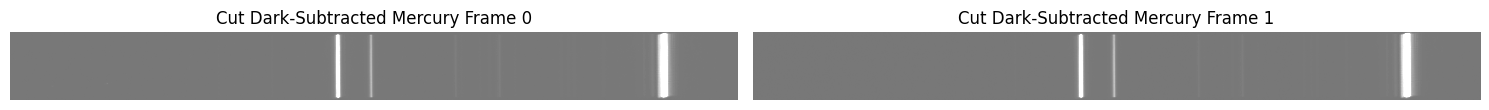

In [123]:
# Display the cut dark-subtracted mercury frames
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(
        cut_dark_subtracted_mercury[i],
        vmin=np.mean(cut_dark_subtracted_mercury[i]) - (2 * np.std(cut_dark_subtracted_mercury[i])),
        vmax=np.mean(cut_dark_subtracted_mercury[i]) + (2 * np.std(cut_dark_subtracted_mercury[i])),
        cmap='gray',
        origin='lower'
    )
    ax.set_title(f"Cut Dark-Subtracted Mercury Frame {i}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# (Don't run) Save cut mercury frames

In [124]:
# # Directory where we will save the cut frames
# save_directory = '/content/drive/MyDrive/AST 443 Group 5/Lab 3/20tau/cut_mercury_arc_lamp'

# # Ensure the directory exists
# os.makedirs(save_directory, exist_ok=True)

# # Save the cut dark-subtracted mercury frames
# for i, frame in enumerate(cut_dark_subtracted_mercury):
#     # Create the filename for each frame
#     filename = f'{save_directory}/cut_mercury_light_120s_.0000000{i}.FIT'

#     # Save the frame as a FITS file
#     fits.writeto(filename, frame, overwrite=True)

# print("Cut dark-subtracted mercury frames have been saved successfully!")

## 1. Sum Each Mercury Frame in 1D along the y-axis.
## 2. Average the 1D Mercury Spectra across all frames to reduce noise.
## 3. Plot the Averaged 1D Mercury Spectrum to identify emission lines for calibration.

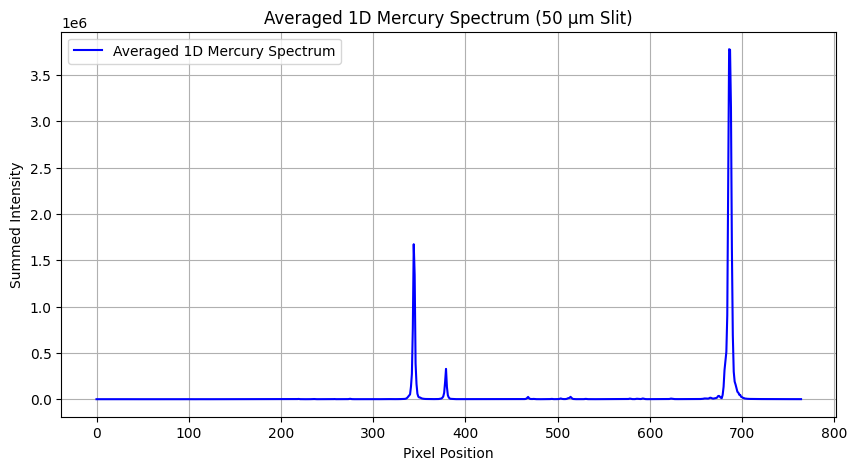

In [125]:
# Step 1: Sum each mercury frame in 1D along the y-axis
summed_mercury = [np.sum(frame, axis=0) for frame in cut_dark_subtracted_mercury]

# Step 2: Average the 1D mercury spectra across all frames
averaged_mercury_spectrum = np.mean(summed_mercury, axis=0)

# Step 3: Plot the averaged 1D mercury spectrum
plt.figure(figsize=(10, 5))
plt.plot(averaged_mercury_spectrum, label="Averaged 1D Mercury Spectrum", color='blue')
plt.title("Averaged 1D Mercury Spectrum (50 µm Slit)")
plt.xlabel("Pixel Position")
plt.ylabel("Summed Intensity")
plt.legend()
plt.grid(True)
plt.show()